<a href="https://colab.research.google.com/github/xteox017/Sintesis-de-reuniones-con-IA-Equipo-31-TEC/blob/main/Modelo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maestría en Inteligencia Artificial Aplicada

PROYECTO INTEGRADOR

**Avance 5. Modelo final**

Equipo 31

JUAN CARLOS VILLAMIL ROJAS A01794003

MATEO CRUZ LANCHERO A01793882

ANDREA MARGARITA OSORIO GONZÁLEZ A01104776

2/6/2024

**Avance #5** (Trabajo en progreso, modelo final aún no definido)

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!pip install moviepy transformers
!pip install openai==0.28
!pip install transformers
!pip install bert-extractive-summarizer
!pip install rouge
!pip install rouge_score

In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import VideoFileClip
from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel
from rouge import Rouge
from summarizer import Summarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from moviepy.editor import VideoFileClip
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import math

# Configuración de estilo para matplotlib
plt.style.use('ggplot')

In [69]:
# Directorios de los videos y resúmenes de referencia
video_dir = '/content/drive/My Drive/Videos/'
reference_summary_dir = '/content/drive/My Drive/Reference_Summaries/'
transcript_dir = '/content/drive/My Drive/Transcripts/'

# Obtener listas de archivos de videos, resúmenes de referencia y transcripciones
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.mp4')]
reference_summaries = [os.path.join(reference_summary_dir, f) for f in os.listdir(reference_summary_dir) if f.endswith('.txt')]
transcript_files = [os.path.join(transcript_dir, f) for f in os.listdir(transcript_dir) if f.endswith('.txt')]

# Ordenar las listas de archivos por nombre de archivo
video_files.sort()
  # Ordenar en su lugar
reference_summaries = sorted(reference_summaries) # Volver a asignar la lista
transcript_files.sort()

# Verificar que el número de videos, resúmenes y transcripciones coincida
assert len(video_files) == len(reference_summaries) == len(transcript_files), "El número de videos, resúmenes de referencia y transcripciones no coincide."

# Verificar que los nombres de los archivos coincidan en las mismas posiciones
for i in range(len(video_files)):
   assert os.path.splitext(os.path.basename(video_files[i]))[0] == os.path.splitext(os.path.basename(reference_summaries[i]))[0] == os.path.splitext(os.path.basename(transcript_files[i]))[0], "Los nombres de los archivos no coinciden en la posición {}".format(i)

# Leer los resúmenes de referencia (corrección: usando reference_summaries)
reference_texts = [open(f).read() for f in reference_summaries]

# Leer las transcripciones
transcripts = [open(f).read() for f in transcript_files]

# Crear un DataFrame para el análisis (ordenar listas antes de crear DataFrame)
data = {
    'Video': [os.path.basename(f) for f in video_files],
    'Transcript': transcripts,
    'Reference Summary': reference_texts
}
df = pd.DataFrame(data)

# Imprimir las primeras 5 filas del DataFrame para verificar
df.head(5)

# Mostrar los nombres de los archivos de los primeros 5 videos
for i in range(5):
    print(f"Video {i+1}: {df['Video'][i]}")

# Mostrar los nombres de los archivos de los primeros 5 videos
#for i in range(5):
    #print(f"Transcript {i+1}: {df['Transcript'][i]}")

# Mostrar los nombres de los archivos de los primeros 5 videos
for i in range(5):
    print(f"Reference Summary {i+1}: {os.path.splitext(os.path.basename(reference_summaries[i]))[0]}")


Video 1: AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO.mp4
Video 2: Axel Kaiser y Javier Milei - El renacimiento liberal.mp4
Video 3: Cómo sobrevivir a la destrucción de la industria de la tecnología.mp4
Video 4: Creencias _ Daniel Habif _ TEDxCiudaddePuebla.mp4
Video 5: El nuevo orden mundial de China y la dependencia de Occidente.mp4
Reference Summary 1: AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO
Reference Summary 2: Axel Kaiser y Javier Milei - El renacimiento liberal
Reference Summary 3: Cómo sobrevivir a la destrucción de la industria de la tecnología
Reference Summary 4: Creencias _ Daniel Habif _ TEDxCiudaddePuebla
Reference Summary 5: El nuevo orden mundial de China y la dependencia de Occidente


In [70]:
print(os.path.splitext(os.path.basename(video_files[0]))[0])

AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO


In [71]:
print(os.path.splitext(os.path.basename(reference_summaries[0]))[0])

AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO


In [72]:
print(os.path.splitext(os.path.basename(transcript_files[0]))[0])

AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO


In [73]:
df['Video']

0     AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIM...
1     Axel Kaiser y Javier Milei - El renacimiento l...
2     Cómo sobrevivir a la destrucción de la indus...
3     Creencias _ Daniel Habif _ TEDxCiudaddePuebla.mp4
4     El nuevo orden mundial de China y la dependenc...
5       Estados Unidos vs. China_La GUERRA de CHIPS.mp4
6     GPT4o - La Gran Apuesta de OpenAI por la MULTI...
7     Google, Facebook, Amazon - El poder ilimitado ...
8     LO QUE DEBEN SABER HOY LOS AFILIADOS de la EPS...
9     La Entrevista que no quiso hacer Gabi Desangle...
10    La barrera de la que no se habla-ENRIQUE VÁZQ...
11                           Musica generado por IA.mp4
12    Persuadir e influir como todo un agente 007_Fe...
13    Pocos Entienden Esto de la Física Moderna....mp4
14    Por los sueños se suspira, por las metas se t...
15                     Respuestas con Áxel Káiser.mp4
16    Somos lo que Pensamos _ Yirko Sivirich _ TEDxL...
17        Te reto a ser feliz _ Omar Chaparro _ 

In [74]:
df['Reference Summary']

0     El programa de debate "Strending Topics" prese...
1     Este video de Youtube presenta una conversació...
2     Este video de Platzi aborda la sensación de cr...
3     En esta charla TEDx, Daniel David reflexiona s...
4     Este documental de DW explora la creciente dep...
5     Este video de Youtube explora la creciente ten...
6     Este video de Youtube analiza la nueva tecnolo...
7     Este documental de DW explora el creciente pod...
8     Este video de Youtube trata sobre la decisión ...
9     Este video de Youtube presenta una conversació...
10    En su charla TEDx, Enrique Vázquez, un psicólo...
11    El video explora el impacto de la Inteligencia...
12    El orador del video, Felipe Riano, argumenta q...
13    Este video de Youtube explica la segunda ley d...
14    En esta charla TEDx, Humberto Ramos, un recono...
15    Este video de Youtube presenta una conversació...
16    En esta charla TEDxLima, Yirko Sivirich, un di...
17    En esta charla TEDx, el actor y comediante

In [75]:
from google.colab import files

# Subir el archivo de la clave de API
#uploaded = files.upload()

# Leer la clave de API
#api_key = None
#for fn in uploaded.keys():
    #with open(fn) as f:
        #api_key = f.read().strip()


In [76]:
#------------> Utilizado para generar las transcripciones, una vez obtenidas no se debe correr de nuevo.
#!pip install pydub
#from pydub import AudioSegment
#import math
#import openai

# Función para dividir el audio en segmentos más pequeños
#def split_audio(audio_path, max_segment_size_bytes=25000000):  # 25 MB
#   audio = AudioSegment.from_file(audio_path)
#    duration_ms = len(audio)
#    segments = []
#    segment_length_ms = 0

    # Calcula la longitud de los segmentos basándose en el tamaño máximo permitido
#    for i in range(duration_ms):
#        if (audio[i:i+1000].frame_rate * audio[i:i+1000].sample_width * audio[i:i+1000].channels * (i+1000) / 8) <= max_segment_size_bytes:
#            segment_length_ms += 1000
#        else:
#            break

#   for start in range(0, duration_ms, segment_length_ms):
#        end = min(start + segment_length_ms, duration_ms)
#        segment = audio[start:end]
#        segment_path = f"segment_{start//1000}_{end//1000}.wav"
#        segment.export(segment_path, format="wav")
#        segments.append(segment_path)

#    return segments

# Configurar la clave de API de OpenAI
#openai.api_key = api_key

#def transcribe_audio_openai(audio_path):
#    audio_file = open(audio_path, "rb")
#    transcript = openai.Audio.transcribe("whisper-1", audio_file)
#    return transcript["text"]

#def transcribe_audio_segments(segments):
#    full_transcript = ""
#    for segment in segments:
#        transcript = transcribe_audio_openai(segment)
#        full_transcript += transcript + " "
#    return full_transcript.strip()
#
#def extract_audio_from_video(video_path):
#    video = VideoFileClip(video_path)
#    audio_path = video_path.replace('.mp4', '.wav')
#    video.audio.write_audiofile(audio_path)
#    return audio_path

# Process each video file
#for video_file in video_files:
    # Extract audio from video
#    audio_path = extract_audio_from_video(video_file)

    # Split audio into smaller segments
#    segments = split_audio(audio_path)

    # Transcribe each segment and combine the transcriptions
#    full_transcript = transcribe_audio_segments(segments)

    # Save the full transcript to a text file
#    transcript_file = video_file.replace('.mp4', '.txt').replace(video_dir, '/content/drive/My Drive/Transcripts/')
#    with open(transcript_file, 'w') as f:
#        f.write(full_transcript)

#    print(f"Transcription for {video_file} saved to {transcript_file}")


Preview of dataframe

In [77]:
df.head(5)

,Video,Transcript,Reference Summary
0,AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIM...,"Pregunta también, sobre todo para Axel, que me...","El programa de debate ""Strending Topics"" prese..."
1,Axel Kaiser y Javier Milei - El renacimiento l...,"Mi nombre es Mara Sedilli, soy Directora de As...",Este video de Youtube presenta una conversació...
2,Cómo sobrevivir a la destrucción de la indus...,¿Cómo sobrevivir a la destrucción que está ocu...,Este video de Platzi aborda la sensación de cr...
3,Creencias _ Daniel Habif _ TEDxCiudaddePuebla.mp4,"Gracias por estar aquí presentes, gracias por ...","En esta charla TEDx, Daniel David reflexiona s..."
4,El nuevo orden mundial de China y la dependenc...,El día sobre el que todos advierten comienza c...,Este documental de DW explora la creciente dep...


In [78]:
len(df)

20

In [79]:
df.isnull().sum()

Video                0
Transcript           0
Reference Summary    0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Video              20 non-null     object
 1   Transcript         20 non-null     object
 2   Reference Summary  20 non-null     object
dtypes: object(3)
memory usage: 608.0+ bytes


Mean Transcript Words: 4869.2
Mean Reference Summary Words: 338.1


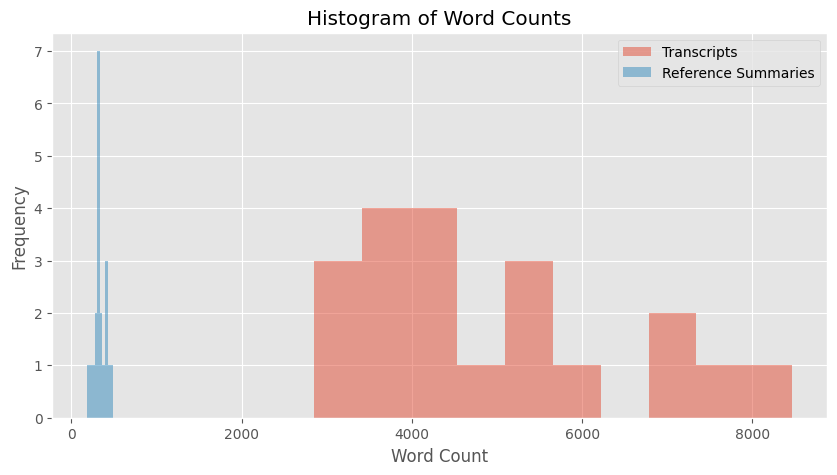

In [81]:
# Número de palabras por transcripción y resumen de referencia
df['Transcript Word Count'] = df['Transcript'].apply(lambda x: len(x.split()))
df['Reference Summary Word Count'] = df['Reference Summary'].apply(lambda x: len(x.split()))

# Duración de cada video transcrito en minutos
video_durations = [VideoFileClip(f).duration / 60 for f in video_files]  # Duración en minutos
df['Video Duration (minutes)'] = video_durations

# Media del número de palabras
mean_transcript_words = df['Transcript Word Count'].mean()
mean_reference_words = df['Reference Summary Word Count'].mean()
print(f"Mean Transcript Words: {mean_transcript_words}")
print(f"Mean Reference Summary Words: {mean_reference_words}")

plt.figure(figsize=(10, 5))
plt.hist(df['Transcript Word Count'], bins=10, alpha=0.5, label='Transcripts')
plt.hist(df['Reference Summary Word Count'], bins=10, alpha=0.5, label='Reference Summaries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
plt.legend(loc='upper right')
plt.show()

In [82]:
df['Transcript'][0]

'Pregunta también, sobre todo para Axel, que me encanta volver a polimizar con él y para los demás también. ¿Qué piensan ustedes de cómo se podría crear empleo en el corto plazo? Besos y abrazos. Ahí está, Marco Enrique Uminami, ya me lo presentó. ¡Ah, mierda! Le metió cruce, le dejó pregunta instalada. ¡Mierda! Error, error. Junto a nosotros, cada vez que habla Strending Topics, saca noticia en todas partes. Acá tiene los récords de programas junto a nosotros, destacado abogado, economista, Axel Kayser. ¿Cómo estás, Axel? Buenas noches, bienvenido. Bien, contento de estar de vuelta acá, Gonzalo. Gracias por la invitación. Qué bueno que Marco se metió en la economía porque eso era exactamente lo que yo quería hablar. No tengo problemas con pensar en obras públicas siempre que sean concesionadas a privado y el Estado no gaste un peso, entre otras razones porque lo que yo quería tocar hoy día es uno de los problemas más graves que enfrenta Chile y del que nadie está hablando. Estamos ent

In [83]:
df['Reference Summary'][0]

'El programa de debate "Strending Topics" presenta una discusión acalorada sobre la situación actual de Chile, con un enfoque en la economía, la seguridad y la política.\nPuntos clave:\nEconomía: Axel Kaiser alerta sobre la situación fiscal crítica de Chile, con una deuda pública cercana al 60% del PIB. Critica la falta de crecimiento económico y la incertidumbre jurídica que obstaculizan la inversión. Propone reformas para crear empleo: reducir el impuesto a las empresas al 20%, reintegrar el sistema de IVA al 100% y derogar la ley de persecución empresarial.\nSeguridad: Pancho Javier acusa al gobierno de tener una agenda que permite la delincuencia, señalando la liberación de presos, la justificación de la violencia y el apoyo al terrorismo en la Araucanía. Natalia Pergentili rechaza la idea de que todos los que están en el gobierno compartan esa agenda, pero admite que existen incumplimientos en materia de seguridad.\nPolítica: El debate se centra en las acciones del gobierno y su s

In [84]:
df['Video'][0]

'AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO.mp4'

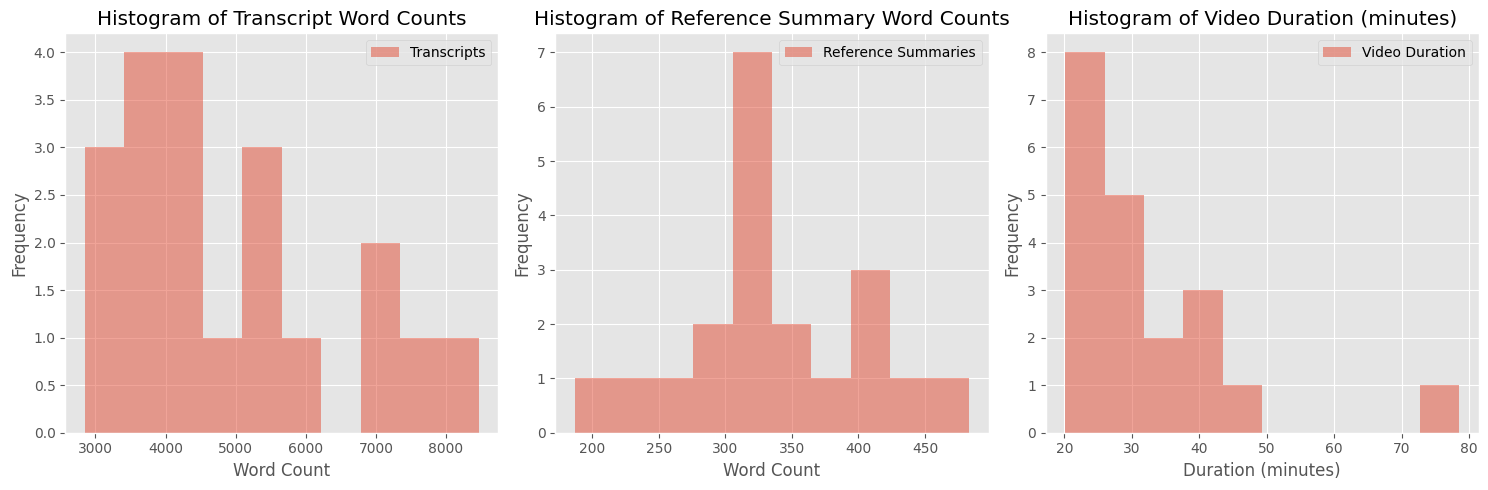

In [85]:
# Histogramas del conteo de palabras y duración de videos
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Transcript Word Count'], bins=10, alpha=0.5, label='Transcripts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Transcript Word Counts')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.hist(df['Reference Summary Word Count'], bins=10, alpha=0.5, label='Reference Summaries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Reference Summary Word Counts')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.hist(df['Video Duration (minutes)'], bins=10, alpha=0.5, label='Video Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Video Duration (minutes)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [86]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 85.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Transcripciones y Resúmenes de Referencia preprocesados:
                                                Video  \
0   AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIM...   
1   Axel Kaiser y Javier Milei - El renacimiento l...   
2   Cómo sobrevivir a la destrucción de la indus...   
3   Creencias _ Daniel Habif _ TEDxCiudaddePuebla.mp4   
4   El nuevo orden mundial de China y la dependenc...   
5     Estados Unidos vs. China_La GUERRA de CHIPS.mp4   
6   GPT4o - La Gran Apuesta de OpenAI por la MULTI...   
7   Google, Facebook, Amazon - El poder ilimitado ...   
8   LO QUE DEBEN SABER HOY LOS AFILIADOS de la EPS...   
9   La Entrevista que no quiso hacer Gabi Desangle...   
10  La barrera de la que no se habla-ENRIQUE VÁZQ...   
11                         Musica generado por IA.mp4   
12  Persuadir e influir como todo un agente 007_Fe...   
13  Pocos Entienden Esto de la Física Moderna....mp4   
14  Por los sueños se suspira, por las metas se t...   
15                   Respuestas

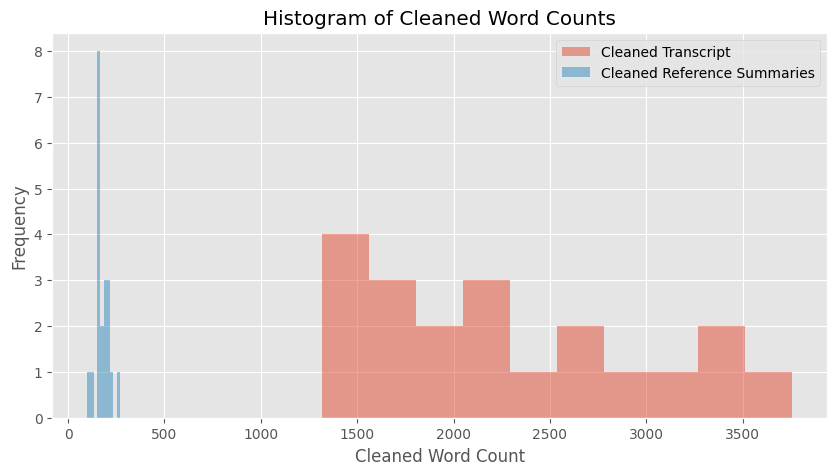

In [87]:
# Funciones para el análisis de datos y preprocesamiento de texto
import spacy
import nltk
from nltk.corpus import stopwords
import re

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("es_core_news_sm")  # Cargar el modelo de SpaCy para español

# Función para limpiar el texto
def clean_text(text):
    text = text.lower()
    # Remover texto entre corchetes
    text = re.sub(r'\[.*?\]', '', text)
    # Remover palabras con números (opcional, puedes mantenerlas)
    # text = re.sub(r'\w*\d\w*', '', text)
    # Remover caracteres especiales
    text = re.sub(r'[%s]' % re.escape(r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)
    # Remover espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para preprocesar el texto
def preprocess_text(text):
    stop_words = set(stopwords.words('spanish'))
    stop_words.update(["uno", "dos", "tres", "cuatro", "cinco", "seis", "siete", "ocho", "nueve", "diez",
                       "si", "voy", "subtítulos", "realizados", "amaraorg", "ahí", "di", "va", "van", "etcétera", "ver", "gracias", "vas", "video", "youtube", "presenta", "conversación", "explora", "charla", "tedx"])  # Agregar palabras adicionales

    # Detectar plurales y evitar lematización
    words = text.split()
    for i, word in enumerate(words):
        # Reglas más completas para detectar plurales
        if word.endswith(("s", "es", "as", "os", "ces", "zes", "ies")) or \
           (word.endswith("a") and word[:-1].endswith(("s", "es", "as", "os", "ces", "zes", "ies"))):
            words[i] = word  # Evita lematizar la palabra

    text = ' '.join(words)  # Reconstruir la frase

    text = clean_text(text)  # Limpiar el texto después de detectar plurales
    doc = nlp(text)

    # Mantener los números como tokens (opcional)
    words = [token.text for token in doc if (token.is_alpha or token.like_num) and token.text.lower() not in stop_words]

    # Omitir palabras que empiezan con "www"
    words = [word for word in words if not word.startswith("www")]

    return ' '.join(words)  # Devuelve la frase preprocesada y None

# Aplicar la limpieza y el preprocesamiento a las transcripciones y los resúmenes de referencia
df['Cleaned Transcript'] = df['Transcript'].apply(preprocess_text)
df['Cleaned Reference Summary'] = df['Reference Summary'].apply(preprocess_text)

print("Transcripciones y Resúmenes de Referencia preprocesados:")
print(df[['Video', 'Cleaned Transcript', 'Cleaned Reference Summary']])

# Número de palabras por transcripción y resumen de referencia
df['Cleaned Transcript']
df['Cleaned Transcript Word Count'] = df['Cleaned Transcript'].apply(lambda x: len(x.split()))
df['Cleaned Reference Summary Word Count'] = df['Cleaned Reference Summary'].apply(lambda x: len(x.split()))

# Media del número de palabras
mean_cleaned_transcript_words = df['Cleaned Transcript Word Count'].mean()
mean_cleaned_reference_words = df['Cleaned Reference Summary Word Count'].mean()
print(f"Mean Cleaned Transcript Words: {mean_cleaned_transcript_words}")
print(f"Mean Cleaned Reference Summary Words: {mean_cleaned_reference_words}")

# Histogramas del conteo de palabras
plt.figure(figsize=(10, 5))
plt.hist(df['Cleaned Transcript Word Count'], bins=10, alpha=0.5, label='Cleaned Transcript')
plt.hist(df['Cleaned Reference Summary Word Count'], bins=10, alpha=0.5, label='Cleaned Reference Summaries')
plt.xlabel('Cleaned Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Cleaned Word Counts')
plt.legend(loc='upper right')
plt.show()

Estadísticas descriptivas de los puntajes de similitud coseno entre las transcripciones y los resúmenes de referencia

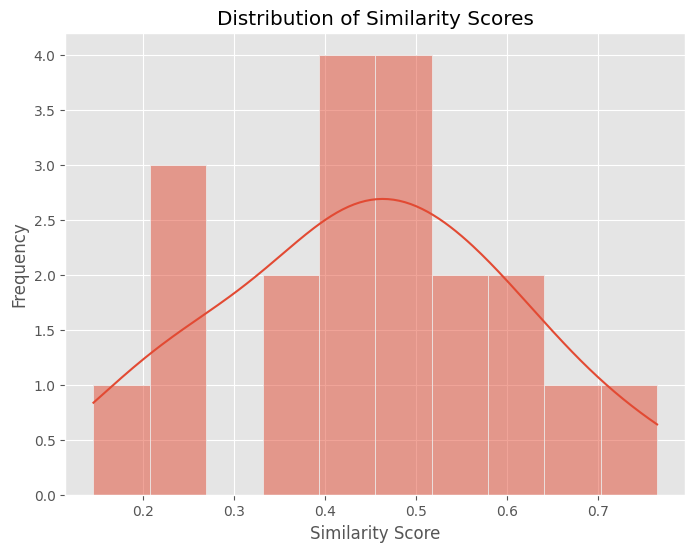

Estadísticas de los puntajes de similitud:
count    20.000000
mean      0.447222
std       0.162233
min       0.144977
25%       0.340444
50%       0.449397
75%       0.567028
max       0.765348
Name: Similarity Score, dtype: float64


In [88]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Cargar el modelo de SpaCy para español con lematización
nlp = spacy.load("es_core_news_sm")

# Función para realizar la lematización
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Aplicar lematización a las transcripciones y los resúmenes de referencia
df['Lemmatized Transcript'] = df['Cleaned Transcript'].apply(lemmatize_text)
df['Lemmatized Reference Summary'] = df['Cleaned Reference Summary'].apply(lemmatize_text)

# Verificar si hay suficientes muestras en las transcripciones y los resúmenes de referencia
if df['Lemmatized Transcript'].notna().sum() > 0 and df['Lemmatized Reference Summary'].notna().sum() > 0:
    # Calcular la similitud coseno entre las transcripciones y los resúmenes de referencia lematizados
    tfidf_vectorizer = TfidfVectorizer()
    transcript_tfidf = tfidf_vectorizer.fit_transform(df['Lemmatized Transcript'])
    reference_tfidf = tfidf_vectorizer.transform(df['Lemmatized Reference Summary'])

    similarity_scores = cosine_similarity(transcript_tfidf, reference_tfidf)
    df['Similarity Score'] = similarity_scores.diagonal()

    # Visualizar la distribución de los puntajes de similitud
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Similarity Score'], bins=10, kde=True)
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similarity Scores')
    plt.show()

    # Calcular estadísticas de los puntajes de similitud
    print("Estadísticas de los puntajes de similitud:")
    print(df['Similarity Score'].describe())
else:
    print("No hay suficientes muestras en las transcripciones o en los resúmenes de referencia para calcular la similitud coseno.")

**count**: Indica el número total de muestras o pares de transcripción-resumen de referencia para los cuales se calculó el puntaje de similitud. En este caso, tienes 20 muestras.

**mean**: Representa el promedio o media aritmética de los puntajes de similitud. Un valor de 0.447222 indica que, en promedio, las transcripciones y los resúmenes de referencia tienen una similitud del 44.72%. Esto sugiere que, en general, las transcripciones y los resúmenes de referencia tienen una similitud moderada.

**std**: Es la desviación estándar de los puntajes de similitud. Un valor de 0.162233 indica la variabilidad o dispersión de los puntajes alrededor de la media. Cuanto mayor sea la desviación estándar, mayor será la variabilidad en los puntajes de similitud.

**min**: Representa el puntaje de similitud mínimo encontrado en el conjunto de datos. Un valor de 0.144977 indica que el par de transcripción-resumen de referencia con la similitud más baja tiene un puntaje de similitud del 14.50%.

**25%, 50%, 75%**: Estos valores corresponden a los percentiles 25, 50 (mediana) y 75 de los puntajes de similitud. El 25% de los pares de transcripción-resumen de referencia tienen un puntaje de similitud inferior a 0.340444, el 50% tienen un puntaje inferior a 0.449397 y el 75% tienen un puntaje inferior a 0.567028.

**max**: Representa el puntaje de similitud máximo encontrado en el conjunto de datos. Un valor de 0.765348 indica que el par de transcripción-resumen de referencia con la similitud más alta tiene un puntaje de similitud del 76.53%.

**Aquí se presenta solo una medida de similitud y no captura todos los aspectos de la calidad de un resumen.**

In [89]:
df['Cleaned Transcript'][0]

'pregunta axel encanta volver polimizar demás piensan ustedes cómo podría crear empleo corto plazo besos abrazos marco enrique uminami presentó ah mierda metió cruce dejó pregunta instalada mierda error error junto cada vez habla strending topics saca noticia todas partes acá récords programas junto destacado abogado economista axel kayser cómo axel buenas noches bienvenido bien contento vuelta acá gonzalo invitación bueno marco metió economía exactamente quería hablar problemas pensar obras públicas siempre concesionadas privado gaste peso razones quería tocar hoy día problemas graves enfrenta chile nadie hablando entrando zona default chile entrando zona quiebra finanzas fiscales escuchábamos argentina países escúchame decir sumas deuda gobierno central deuda empresas estatales deuda municipalidades todas cosas pagar contribuyentes llegas casi 60 producto 60 pib 180 mil millones dólares 9 mil dólares habitante podemos pagar llevamos 10 años déficit efectivo promedio 25 dónde ido plat

In [90]:
df['Cleaned Reference Summary'][0]

'programa debate strending topics discusión acalorada situación actual chile enfoque economía seguridad política puntos clave economía axel kaiser alerta situación fiscal crítica chile deuda pública cercana 60 pib critica falta crecimiento económico incertidumbre jurídica obstaculizan inversión propone reformas crear empleo reducir impuesto empresas 20 reintegrar sistema iva 100 derogar ley persecución empresarial seguridad pancho javier acusa gobierno tener agenda permite delincuencia señalando liberación presos justificación violencia apoyo terrorismo araucanía natalia pergentili rechaza idea gobierno compartan agenda admite existen incumplimientos materia seguridad política debate centra acciones gobierno supuesta falta agenda axel kaiser critica gestión gobierno señala michelle bachelet responsable deterioro económico actual panel analiza reformas impulsadas gobierno reforma salud pensiones consecuencias podrían tener futuro giorgio jackson discute demanda giorgio jackson 23 diputa

In [91]:
cnt=0
for i in df['Cleaned Reference Summary']:
    if(len(i.split())<=225):
        cnt=cnt+1
print(cnt/len(df['Cleaned Reference Summary']))

0.9


In [92]:
cnt=0
for i in df['Cleaned Transcript']:
    if(len(i.split())<=3350):
        cnt=cnt+1
print(cnt/len(df['Cleaned Transcript']))

0.9


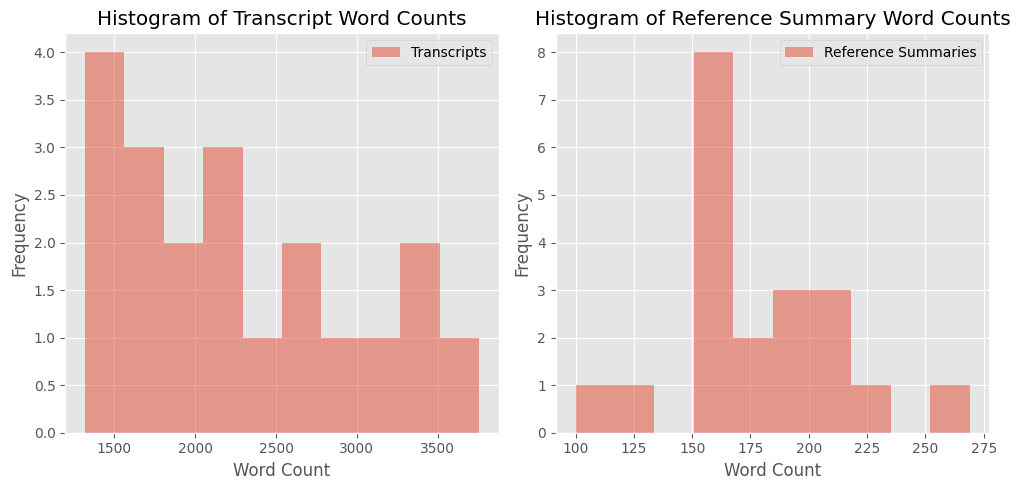

In [93]:
# Histogramas del conteo de palabras y duración de videos
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Cleaned Transcript Word Count'], bins=10, alpha=0.5, label='Transcripts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Transcript Word Counts')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.hist(df['Cleaned Reference Summary Word Count'], bins=10, alpha=0.5, label='Reference Summaries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Reference Summary Word Counts')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [94]:
df_limpio = pd.DataFrame({
    'Video': df['Video'],
    'Transcript': df['Cleaned Transcript'],
    'Reference Summary': df['Cleaned Reference Summary']
})

df_limpio.to_csv('df_limpio.csv', index=False)

df_limpio.head(5)

,Video,Transcript,Reference Summary
0,AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIM...,pregunta axel encanta volver polimizar demás p...,programa debate strending topics discusión aca...
1,Axel Kaiser y Javier Milei - El renacimiento l...,nombre mara sedilli directora asuntos públicos...,economista escritor libertario áxel kaiser dip...
2,Cómo sobrevivir a la destrucción de la indus...,cómo sobrevivir destrucción ocurriendo industr...,platzi aborda sensación crisis industria tecno...
3,Creencias _ Daniel Habif _ TEDxCiudaddePuebla.mp4,aquí presentes permitirme formar parte pedazo ...,daniel david reflexiona vida experiencias dest...
4,El nuevo orden mundial de China y la dependenc...,día advierten comienza noticia alarmante china...,documental dw creciente dependencia alemania h...


Analyzing n-grams - Transcript

In [95]:
X = df['Cleaned Transcript']
y = df.drop('Cleaned Transcript', axis=1)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (3,3))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_tri_labels = X_count.sum().sort_values(ascending = False)[0:30]

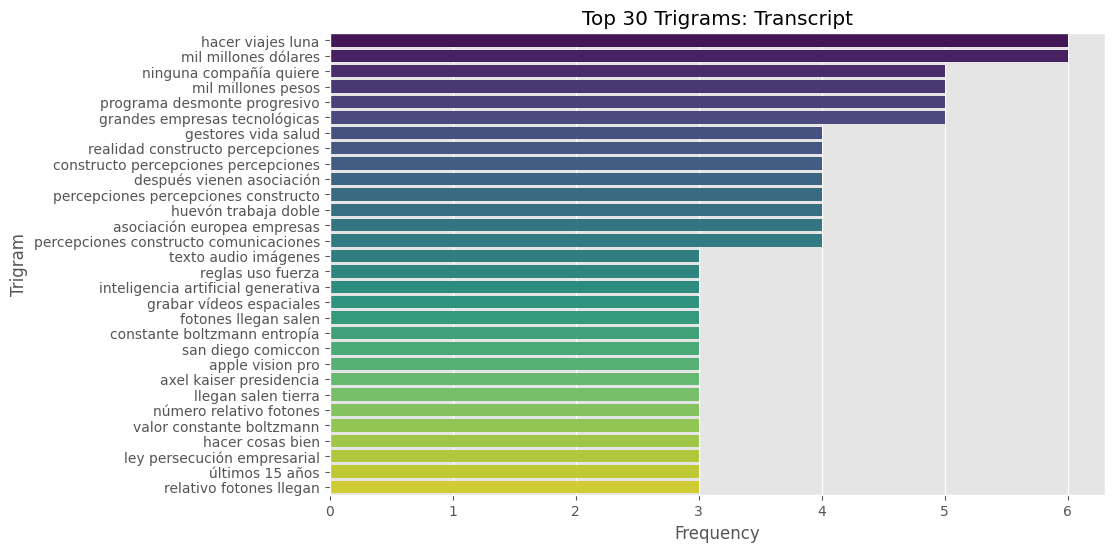

In [97]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=all_tri_labels.values, y=all_tri_labels.index, palette='viridis')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 30 Trigrams: Transcript')

# Display the plot
plt.show()

Analyzing n-grams - Reference Summary

In [98]:
X = df['Cleaned Reference Summary']
y = df.drop('Cleaned Reference Summary', axis=1)

In [99]:
cv = CountVectorizer(ngram_range = (3,3))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_tri_labels = X_count.sum().sort_values(ascending = False)[0:30]

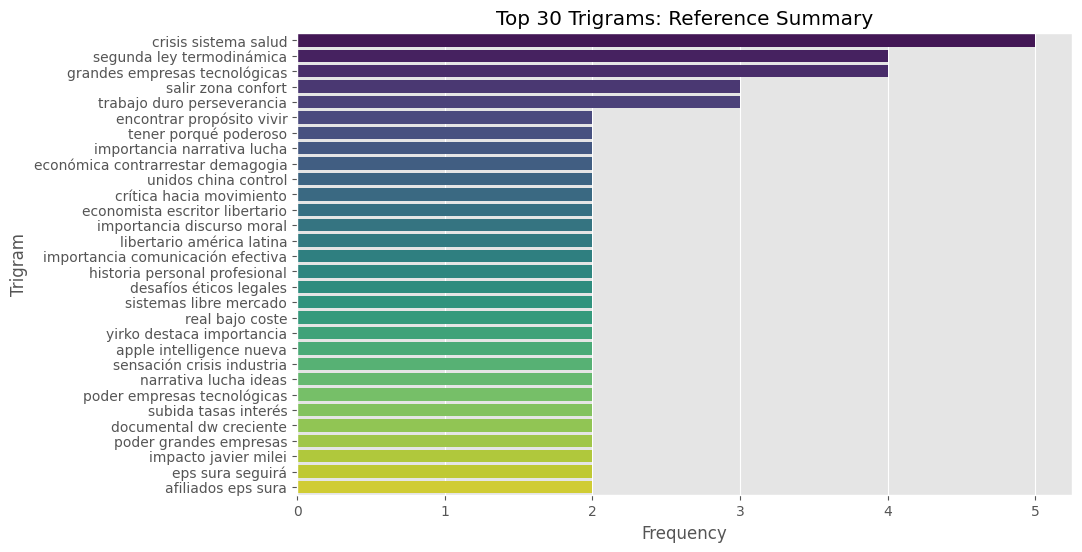

In [100]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=all_tri_labels.values, y=all_tri_labels.index, palette='viridis')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 30 Trigrams: Reference Summary')

# Display the plot
plt.show()

BASE LINE

In [101]:
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from rouge import Rouge

def random_sentence_extraction(text, num_sentences=10):
    sentences = text.split('. ')
    num_sentences = min(num_sentences, len(sentences))
    random_sentences = random.sample(sentences, num_sentences)
    summary = '. '.join(random_sentences) + '.'
    return summary

# Aplicar el modelo de Extracción de Oraciones Aleatorias a las transcripciones
df['Random Extraction Summary'] = df['Transcript'].apply(lambda x: random_sentence_extraction(x))

# Calcular la puntuación ROUGE entre los resúmenes generados por el modelo baseline y los resúmenes de referencia
rouge = Rouge()

rouge_scores = []
for i in range(len(df)):
    summary = df['Random Extraction Summary'][i]
    reference = df['Reference Summary'][i]
    scores = rouge.get_scores(summary, reference)[0]
    rouge_scores.append(scores)

# Mostrar las puntuaciones ROUGE promedio
rouge_1 = np.mean([score['rouge-1']['f'] for score in rouge_scores])
rouge_2 = np.mean([score['rouge-2']['f'] for score in rouge_scores])
rouge_l = np.mean([score['rouge-l']['f'] for score in rouge_scores])

print("Puntuaciones ROUGE promedio para el modelo baseline (Extracción de Oraciones Aleatorias):")
print(f"ROUGE-1: {rouge_1:.4f}")
print(f"ROUGE-2: {rouge_2:.4f}")
print(f"ROUGE-L: {rouge_l:.4f}")

Puntuaciones ROUGE promedio para el modelo baseline (Extracción de Oraciones Aleatorias):
ROUGE-1: 0.1748
ROUGE-2: 0.0332
ROUGE-L: 0.1548


In [102]:
df['Random Extraction Summary'][19]

'Y Carmen no tiene cliente. A esa altura Nina ya era casi una experta en todo este asunto. Le expliqué que los fajos de Ernesto reciben el nombre de obligaciones de deuda mientras que la casa de Quique, el lugar a donde van los vecinos para saber si confían o no en los fajos de Ernesto, se llaman banca de inversión. Cuando llegó la cuarta semana, y se cumplió el mes, Pepe se levantó muy temprano y caminó tranquilo hasta el pueblo. Siempre hay que testear las metáforas con los chicos, sobre todo cuando son ideas complejas. Muchos vecinos habían pasado la noche entera recortando sus propios papelitos porque también habían descubierto que tenían proyectos que no podían cumplir por falta de moneda. Cada cartel que ponía se iba lejos, y se quedaba orgulloso, mirando el cartel. Porque en el medio aparecen Quiques, aparecen alcaldes, aparecen Ernestos y secretarios, y lo echan siempre todo a perder. y dijo, cuidado vecinos, cuidado, los fajos de Ernesto a veces vienen con papelitos de Pepe o 

Se define una función random_sentence_extraction que
toma como entrada un texto y un número deseado de oraciones para el resumen (por defecto, 10). Esta función divide el texto en oraciones, selecciona aleatoriamente el número especificado de oraciones y las combina para formar el resumen.

Se aplica la función random_sentence_extraction a la columna 'Transcript' del DataFrame utilizando apply y se crea una nueva columna 'Random Extraction Summary' con los resúmenes generados por el modelo baseline.

Se calcula la puntuación ROUGE entre los resúmenes generados por el modelo baseline y los resúmenes de referencia. Para cada par de resumen generado y resumen de referencia, se utiliza la biblioteca rouge para calcular las puntuaciones ROUGE-1, ROUGE-2 y ROUGE-L. Los resultados se almacenan en la lista rouge_scores.

Se calculan las puntuaciones ROUGE promedio (ROUGE-1, ROUGE-2 y ROUGE-L) utilizando las puntuaciones individuales almacenadas en rouge_scores.

Se imprimen las puntuaciones ROUGE promedio para el modelo baseline.

In [103]:
# --- Modelos de Resumen ---

# Función para dividir el texto en partes más pequeñas
def split_text(text, max_length=512):
    sentences = text.split('. ')
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())
        if current_length + sentence_length > max_length:
            # Solo agrega el chunk si tiene contenido
            if current_chunk:
                chunks.append('. '.join(current_chunk) + '.')
            current_chunk = [sentence]
            current_length = sentence_length
        else:
            current_chunk.append(sentence)
            current_length += sentence_length

    # Solo agrega el último chunk si tiene contenido
    if current_chunk:
        chunks.append('. '.join(current_chunk) + '.')

    return chunks

# Función para resumir cada parte del texto
def summarize_text_chunks(chunks, summarizer):
    summaries = []  # Declarar summaries como una lista vacía
    total_time = 0

    for chunk in chunks:
        input_length = len(chunk.split())
        max_length = min(150, input_length)  # Ajustar max_length a la longitud del fragmento
        min_length = max(25, max_length // 2)  # Ajustar min_length basado en max_length

        if input_length > 5:
            start_time = time.time()
            try:
                # Call directly if it's BART or Pegasus
                if summarizer.__name__ in ['summarize_with_bart', 'summarize_with_pegasus', 'T5-Base', 'Textrank']:
                    summary, time_taken = summarizer(' '.join(chunks))
                else:  # Other models that handle max_length and min_length
                    summary = summarizer(chunk, max_length=max_length, min_length=min_length, do_sample=False)
                    # Verificar si el modelo devuelve una lista con el resumen
                    if isinstance(summary, list) and len(summary) > 0 and 'summary_text' in summary[0]:
                        summaries.append(summary[0]['summary_text'])
                    else:
                        print(f"El modelo no devolvió un resumen válido: {summary}")
                        summaries.append(chunk)  # Añadir el fragmento original si hay un error
            except Exception as e:
                print(f"Error al resumir el fragmento: {e}")
                summaries.append(chunk)  # Añadir el fragmento original si hay un error
            end_time = time.time()
            elapsed_time = end_time - start_time
            total_time += elapsed_time
        else:
            summaries.append(chunk)  # Si el fragmento es muy corto, usarlo como está
    return ' '.join(summaries), total_time



In [104]:
# ---  Modelos de Resumen ---

from transformers import PegasusTokenizer, PegasusForConditionalGeneration

pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
pegasus_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

def summarize_with_pegasus(text):
    start_time = time.time()
    inputs = pegasus_tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = pegasus_model.generate(inputs['input_ids'], max_length=150, min_length=30, num_beams=4, early_stopping=True)
    summary = pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return summary, elapsed_time

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def kmeans_summarization(text, num_sentences=10):
    sentences = sent_tokenize(text)
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    kmeans = KMeans(n_clusters=num_sentences)
    kmeans.fit(sentence_vectors)
    centers = kmeans.cluster_centers_
    closest_sentences = []
    for center in centers:
        distances = cosine_similarity(sentence_vectors, [center])
        closest_sentence_index = distances.argmax()
        closest_sentences.append(sentences[closest_sentence_index])
    summary = ' '.join(closest_sentences)
    return summary

# Aplicar el modelo de Resumen Extractivo utilizando K-Means a las transcripciones
df['KMeans Summary'] = df['Transcript'].apply(lambda x: kmeans_summarization(x))

In [106]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

def t5_summarization(text, max_length=200):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Aplicar el modelo T5 a las transcripciones
df['T5 Summary'] = df['Transcript'].apply(lambda x: t5_summarization(x))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [107]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def bart_summarization(text, max_length=200):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Aplicar el modelo BART a las transcripciones
df['BART Summary'] = df['Transcript'].apply(lambda x: bart_summarization(x))

In [108]:
from sklearn.decomposition import TruncatedSVD

def lsa_summarization(text, num_sentences=10):
    sentences = sent_tokenize(text)
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    lsa_model = TruncatedSVD(n_components=num_sentences)
    lsa_model.fit(sentence_vectors)
    lsa_scores = lsa_model.transform(sentence_vectors)
    top_sentences = [sentences[i] for i in lsa_scores.argmax(axis=0)]
    summary = ' '.join(top_sentences)
    return summary

# Aplicar el modelo LSA a las transcripciones
df['LSA Summary'] = df['Transcript'].apply(lambda x: lsa_summarization(x))

In [109]:
!pip install sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

def lexrank_summarization(text, num_sentences=10):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    summary_text = ' '.join([str(sentence) for sentence in summary])
    return summary_text

# Aplicar el modelo LexRank a las transcripciones
df['LexRank Summary'] = df['Transcript'].apply(lambda x: lexrank_summarization(x))

In [110]:
# Función para generar resumen con TF-IDF con medición de tiempo
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

def summarize_with_tfidf(text):
    start_time = time.time()

    sentences = sent_tokenize(text)

    # 1. Preprocesamiento del texto
    clean_words = text_preprocessing(sentences)

    # 2. Creación de la matriz TF
    tf_matrix = create_tf_matrix(sentences)

    # 3. Creación de la matriz IDF
    idf_matrix = create_idf_matrix(sentences)

    # 4. Calculo de la matriz TF-IDF
    tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

    # 5. Calculo de la puntuación de las frases
    sentence_value = create_sentence_score_table(tf_idf_matrix)

    # 6. Determinación del umbral
    threshold = find_average_score(sentence_value)

    # 7. Generación del resumen
    summary = generate_summary(sentences, sentence_value, threshold)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return summary, elapsed_time

def text_preprocessing(sentences):
    """
    Preprocesamiento del texto para eliminar palabras innecesarias.
    """
    stop_words = set(stopwords.words('spanish'))  # Ajustar para español
    ps = SnowballStemmer("spanish")  # Define el stemmer aquí
    clean_words = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [ps.stem(word.lower()) for word in words if word.isalnum()]  # Stemming en español
        clean_words += [word for word in words if word not in stop_words]
    return clean_words

def create_tf_matrix(sentences):
    """
    Crea una matriz de frecuencia de términos (TF).
    TF(t) = (Número de veces que el término t aparece en un documento) / (Número total de términos en el documento)
    """
    tf_matrix = {}
    for sentence in sentences:
        tf_table = {}
        words_count = len(word_tokenize(sentence))
        words = word_tokenize(sentence)
        word_freq = {}
        for word in words:
            word_freq[word] = (word_freq[word] + 1) if word in word_freq else 1
        for word, count in word_freq.items():
            tf_table[word] = count / words_count
        tf_matrix[sentence[:15]] = tf_table
    return tf_matrix

def create_idf_matrix(sentences):
    """
    Crea una matriz de frecuencia de documentos inversa (IDF).
    IDF(t) = log_e(Número total de documentos / Número de documentos con el término t en ellos)
    """
    idf_matrix = {}
    documents_count = len(sentences)
    sentence_word_table = {}
    for sentence in sentences:
        words = word_tokenize(sentence)
        sentence_word_table[sentence[:15]] = words
    word_in_docs = {}
    for sent, words in sentence_word_table.items():
        for word in words:
            word_in_docs[word] = (word_in_docs[word] + 1) if word in word_in_docs else 1
    for sent, words in sentence_word_table.items():
        idf_table = {}
        for word in words:
            idf_table[word] = math.log10(documents_count / float(word_in_docs[word]))
        idf_matrix[sent] = idf_table
    return idf_matrix

def create_tf_idf_matrix(tf_matrix, idf_matrix):
    """
    Crea una matriz TF-IDF que es la multiplicación de tf * idf para cada palabra individual.
    """
    tf_idf_matrix = {}
    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):
        tf_idf_table = {}
        for (word1, value1), (word2, value2) in zip(f_table1.items(), f_table2.items()):
            tf_idf_table[word1] = float(value1 * value2)
        tf_idf_matrix[sent1] = tf_idf_table
    return tf_idf_matrix

def create_sentence_score_table(tf_idf_matrix):
    """
    Determina la puntuación promedio de las palabras de la frase con su valor TF-IDF.
    """
    sentence_value = {}
    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0
        count_words_in_sentence = len(f_table)
        if count_words_in_sentence != 0:
            for word, score in f_table.items():
                total_score_per_sentence += score
            sentence_value[sent] = total_score_per_sentence / count_words_in_sentence
        else:
            sentence_value[sent] = 0
    return sentence_value

def find_average_score(sentence_value):
    """
    Calcula el valor promedio de una frase en la tabla de puntuación de frases.
    """
    sum = 0
    for val in sentence_value:
        sum += sentence_value[val]
    average = sum / len(sentence_value)
    return average

def generate_summary(sentences, sentence_value, threshold):
    """
    Genera un resumen extrayendo las frases con puntuaciones mayores que el valor umbral.
    """
    sentence_count = 0
    summary = ''
    for sentence in sentences:
        if sentence[:15] in sentence_value and sentence_value[sentence[:15]] >= threshold:
            summary += sentence + " "
            sentence_count += 1
    return summary


In [111]:
# --- Evaluación de Modelos ---

modelos = {
    'Pegasus': summarize_with_pegasus,
    'KMeans': kmeans_summarization,
    'T5': t5_summarization,
    'BART': bart_summarization,
    'LSA': lsa_summarization,
    'LexRank': lexrank_summarization,
    'TF-IDF': summarize_with_tfidf
}

# Función para calcular y comparar ROUGE
def evaluar_modelos(df):
    resultados = []
    rouge = Rouge()

    # Ajustar el límite de recursión
    import sys
    sys.setrecursionlimit(2000)

    # Asegurarse de que los textos no sean demasiado largos
    max_evaluation_length = 512

    # Función para evaluar ROUGE de manera segura
    def safe_rouge_score(summary, reference, rouge):
        if not summary.strip():
            return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
        return rouge.get_scores(summary[:max_evaluation_length], reference[:max_evaluation_length])[0]

    for i in range(len(df)):
        # Obtener la transcripcion y resumen de referencia
        transcript = df['Transcript'][i]
        reference_summary = df['Reference Summary'][i]

        # Evaluar cada modelo
        for model_name, model_func in modelos.items():
            print(f"Ejecutando modelo: {model_name}")  # Imprime el modelo actual
            print(f"Procesando video: {df['Video'][i]}")  # Imprime el video actual

            try:
                if model_name == 'TF-IDF':
                    cleaned_transcript = df['Cleaned Transcript'][i]
                    cleaned_reference_summary = df['Cleaned Reference Summary'][i]
                    summary, time_taken = model_func(cleaned_transcript)
                    scores = safe_rouge_score(summary, cleaned_reference_summary, rouge)
                elif model_name in ['KMeans', 'LexRank', 'LSA']:
                    summary, time_taken = model_func(transcript)
                    scores = safe_rouge_score(summary, reference_summary, rouge)
                elif model_name in ['T5', 'BART', 'Pegasus']:
                    chunks = split_text(transcript)
                    summary, time_taken = summarize_text_chunks(chunks, model_func)
                    scores = safe_rouge_score(summary, reference_summary, rouge)
                else:
                    summary, time_taken = model_func(transcript)
                    scores = safe_rouge_score(summary, reference_summary, rouge)
            except Exception as e:
                print(f"Error al resumir el fragmento: {e}")
                summary = ""  # Asignar un resumen vacío si hay error
                time_taken = 0  # Asignar tiempo 0 si hay error
                scores = {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}

            # Agregar los resultados a la lista
            resultados.append({
                'Video': df['Video'][i],
                'Modelo': model_name,
                'rouge1': scores['rouge-1']['f'],
                'rouge2': scores['rouge-2']['f'],
                'rougeL': scores['rouge-l']['f'],
                'Tiempo': time_taken,
                'Resumen Generado': summary,  # Agregar el resumen generado
                'Transcripción': transcript,  # Agregar la transcripcion
                'Resumen Referente': reference_summary  # Agregar el resumen referente
            })

            # Mostrar información del primer video y preguntar si continuar
            if i == 0 and model_name == 'TF-IDF':
                print(f"Transcripción: {transcript}")
                print(f"Resumen Referente: {reference_summary}")
                print(f"Resumen Generado: {summary}")
                print(f"Puntajes ROUGE: {scores}")
                continuar = input("¿Desea continuar con la evaluación? (s/n): ")
                if continuar.lower() != 's':
                    # Crear un DataFrame con los resultados parciales
                    resultados_df = pd.DataFrame(resultados)

                    # Guardar resultados_df en un archivo .csv
                    resultados_df.to_csv('resultados_resumen_parcial.csv', index=False)

                    return  # Devuelve los resultados hasta ahora

    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame(resultados)

    # Calcular el promedio de ROUGE por modelo
    promedio_rouge = resultados_df.groupby('Modelo')[['rouge1', 'rouge2', 'rougeL']].mean()

    # Mostrar el promedio de ROUGE por modelo
    print("Promedio de ROUGE por modelo:")
    print(promedio_rouge)

    # Guardar resultados_df en un archivo .csv
    resultados_df.to_csv('resultados_resumen.csv', index=False)
    return resultados_df

# Llamar a la función evaluar_modelos y mostrar los resultados
resultados_df = evaluar_modelos(df)
print(resultados_df)

Ejecutando modelo: Pegasus
Procesando video: AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO.mp4
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fragmento: index out of range in self
Error al resumir el fr

In [112]:
from transformers import BartTokenizer, BartForConditionalGeneration
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

def summarize_with_bart(text):
    start_time = time.time()
    inputs = bart_tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs['input_ids'], max_length=150, min_length=30, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return summary, elapsed_time

In [113]:
# Función para generar resumen con LSA con medición de tiempo
def summarize_with_lsa(text):
    start_time = time.time()
    sentences = text.split('. ')
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    lsa = TruncatedSVD(n_components=1, n_iter=100)
    lsa.fit(X)
    scores = lsa.components_[0]

    ranked_indices = np.argsort(scores, axis=0)[::-1]
    ranked_sentences = [sentences[i] for i in ranked_indices if i < len(sentences)]

    summary = '. '.join(ranked_sentences[:5])
    end_time = time.time()
    elapsed_time = end_time - start_time
    return summary, elapsed_time

In [114]:
df['Cleaned Transcript'][0]

'pregunta axel encanta volver polimizar demás piensan ustedes cómo podría crear empleo corto plazo besos abrazos marco enrique uminami presentó ah mierda metió cruce dejó pregunta instalada mierda error error junto cada vez habla strending topics saca noticia todas partes acá récords programas junto destacado abogado economista axel kayser cómo axel buenas noches bienvenido bien contento vuelta acá gonzalo invitación bueno marco metió economía exactamente quería hablar problemas pensar obras públicas siempre concesionadas privado gaste peso razones quería tocar hoy día problemas graves enfrenta chile nadie hablando entrando zona default chile entrando zona quiebra finanzas fiscales escuchábamos argentina países escúchame decir sumas deuda gobierno central deuda empresas estatales deuda municipalidades todas cosas pagar contribuyentes llegas casi 60 producto 60 pib 180 mil millones dólares 9 mil dólares habitante podemos pagar llevamos 10 años déficit efectivo promedio 25 dónde ido plat

In [115]:
# --- Evaluación de Modelos ---

modelos = {
    'T5-Base': pipeline("summarization", model="t5-base"),
    'LSA': summarize_with_lsa,
    'TF-IDF': summarize_with_tfidf,
    'Textrank': pipeline("summarization", model="sshleifer/distilbart-cnn-12-6"),
    'Pegasus': summarize_with_pegasus
}

# Función para calcular y comparar ROUGE
def evaluar_modelos(df):
    resultados = []
    rouge = Rouge()

     # Ajustar el límite de recursión
    import sys
    sys.setrecursionlimit(2000)

    # Asegurarse de que los textos no sean demasiado largos
    max_evaluation_length = 512

    # Validar el orden de los datos
    #assert df['Video'].tolist() == sorted(df['Video'].tolist()), "El orden de los videos en el DataFrame no es correcto."
    #assert df['Transcript'].tolist() == sorted(df['Transcript'].tolist()), "El orden de las transcripciones en el DataFrame no es correcto."
    #assert df['Reference Summary'].tolist() == sorted(df['Reference Summary'].tolist()), "El orden de los resúmenes de referencia en el DataFrame no es correcto."

     # Función para evaluar ROUGE de manera segura
    def safe_rouge_score(summary, reference, rouge):
        if not summary.strip():
            return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
        return rouge.get_scores(summary[:max_evaluation_length], reference[:max_evaluation_length])[0]

    for i in range(len(df)):
        # Obtener la transcripcion y resumen de referencia
        transcript = df['Transcript'][i]
        reference_summary = df['Reference Summary'][i]

        # Dividir el texto en fragmentos
        chunks = split_text(transcript)

        # Evaluar cada modelo
        for model_name, model_func in modelos.items():
            print(f"Ejecutando modelo: {model_name}")  # Imprime el modelo actual
            print(f"Procesando video: {df['Video'][i]}")  # Imprime el video actual

            # Si es TF-IDF, utilizar la transcripcion limpia
            if model_name == 'TF-IDF':
                cleaned_transcript = df['Cleaned Transcript'][i]
                cleaned_reference_summary = df['Cleaned Reference Summary'][i]
                summary, time_taken = model_func(cleaned_transcript)
                scores = safe_rouge_score(summary, cleaned_reference_summary, rouge)
            # Para los demás modelos, utilizar la transcripcion original
            else:
                if model_name in ['DistilBART-CNN', 'T5-Base', 'Textrank', 'BART', 'Pegasus']:
                    try:
                        summary, time_taken = summarize_text_chunks(chunks.copy(), model_func)
                    except Exception as e:
                        print(f"Error al resumir el fragmento: {e}")
                        summary = ""  # Asignar un resumen vacío si hay error
                        time_taken = 0  # Asignar tiempo 0 si hay error
                else:
                    summary, time_taken = model_func(transcript)
                scores = safe_rouge_score(summary, reference_summary, rouge)

            # Agregar los resultados a la lista
            resultados.append({
                'Video': df['Video'][i],
                'Modelo': model_name,
                'rouge1': scores['rouge-1']['f'],
                'rouge2': scores['rouge-2']['f'],
                'rougeL': scores['rouge-l']['f'],
                'Tiempo': time_taken,
                'Resumen Generado': summary,  # Agregar el resumen generado
                'Transcripción': transcript,  # Agregar la transcripcion
                'Resumen Referente': reference_summary  # Agregar el resumen referente
            })

          # Mostrar información del primer video y preguntar si continuar
            if i == 0 and model_name == 'Pegasus':
                print(f"Transcripción: {transcript}")
                print(f"Resumen Referente: {reference_summary}")
                print(f"Resumen Generado: {summary}")
                print(f"Puntajes ROUGE: {scores}")
                continuar = input("¿Desea continuar con la evaluación? (s/n): ")
                if continuar.lower() != 's':
                    # Crear un DataFrame con los resultados parciales
                    resultados_df = pd.DataFrame(resultados)

                    # Guardar resultados_df en un archivo .csv
                    resultados_df.to_csv('resultados_resumen_parcial.csv', index=False)

                    return  # Devuelve los resultados hasta ahora

    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame(resultados)

     # Calcular el promedio de ROUGE por modelo
    promedio_rouge = resultados_df.groupby('Modelo')[['rouge1', 'rouge2', 'rougeL']].mean()

    # Mostrar el promedio de ROUGE por modelo
    print("Promedio de ROUGE por modelo:")
    print(promedio_rouge)

    # Guardar resultados_df en un archivo .csv
    resultados_df.to_csv('resultados_resumen.csv', index=False)
    return resultados_df

# Llamar a la función evaluar_modelos y mostrar los resultados
resultados_df = evaluar_modelos(df)
print(resultados_df)


Ejecutando modelo: T5-Base
Procesando video: AXEL KAISER y BRUTAL PARTICIPACIÓN en su PRIMER CAPÍTULO.mp4
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__name__'
Error al resumir el fragmento: 'SummarizationPipeline' object has no attribute '__